In [110]:
import numpy as np
import pandas as pd
import matplotlib
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import copy
import os
import shutil

from sklearn.tree import export_graphviz
import graphviz

%matplotlib inline
matplotlib.use('module://ipykernel.pylab.backend_inline')

RANDOM_STATE = 20

In [111]:
n_samples =None
memory_experiment = "pm"
remove_na = True

second_visit = 2
gender = None
iqr_coefficient = None # if None then no standrat removal of outliers
outcome = f"z_global.{second_visit}"
# outcome = f"z_change_snap_game_true_pos_rt_avrg.0.{second_visit}"
# outcome =f"z_change_log_pairs_matching_sum_incorrect.0.{second_visit}"
# outcome = f"z_change_num_memory_max_digits_remembered_correctly.0.{second_visit}"

input_file = f"/projects/prime/ukbb/results_2024/{memory_experiment}_sg_0_{second_visit}_09_06_all_learning/data_with_na.csv"
output_dir = f"/projects/prime/ukbb/results_2024/{memory_experiment}_sg_0_{second_visit}_09_06_all_learning/dtree_classifier_allpredictors_{outcome}"

if gender is None:
  output_dir = f"{output_dir}/"
else:
  output_dir = f"{output_dir}_gender_{gender}/"
if not os.path.exists(output_dir):
  os.makedirs(output_dir)



In [112]:
# function for removing outliers via iqr approach
def remove_outliers_iqr(df_, iqr_cf,  outliers):
    print(f"# data points before removing outliers: {len(df_)}")
    if iqr_cf is not None:
        
        lower_bound = {}
        upper_bound = {}
        
        for feat  in outliers:
            print(f"{feat}")
            
            Q1 = df_[feat].quantile(0.25)
            Q3 = df_[feat].quantile(0.75)
            
            IQR = Q3-Q1
            lower_bound[feat] = Q1 - iqr_cf * IQR
            upper_bound[feat] = Q3 + iqr_cf * IQR
            
            
            
        for feat in lower_bound:
            df_= df_[(df_[feat] >= lower_bound[feat]) & (df_[feat] <= upper_bound[feat])]
            
        print(f"# data points after removing outliers: {len(df_)}")
    return(df_)

In [113]:
predictors = ["gender.0", f"time_difference.0.{second_visit}", "age_years.0", "education_level.0", 
              "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0",
               "Syst_bp.0", "Diast_bp.0", "hdl_conv.0", "ldl_conv.0",  "HbA1c_conv.0",  "C_reactive_protein.0", "waist_cm.0",  "bmi_kg_m2.0",
               "oily_fish_gpday_bradbury.0", "white_fish_gpday_bradbury.0", 
   "red_meat_bradbury_gpd.0", "poultry_gpday_bradbury.0",
   "processed_meat_gpday_bradbury.0", "veg_gpday_bradbury.0",
   "fruit_gpday_bradbury.0", "bread_gpday_bradbury.0", "cheese_gpday_bradbury.0",
    "tea_gpday_bradbury.0", 
    "red_wine_gpd.0", "white_wine_gpd.0", "fortified_gpd.0", "beer_cider_gpd.0", "spirits_gpd.0",
    "aspirin.0",  "anxiety_tr.0", "pain_tr.0", "TAZD_Thiazide.0",  
   "loop_diuretics.0",  "potassium_diuretics.0", "beta_blockers.0", "calcium_antagonists.0", 
   "ARA_II_Antagonists_of_angiotensin_II_receptors.0", "IECA_Angiotensin_converting_enzyme_inhibitors.0",
   "Other_Hypotensive.0","hypochol_statins.0", "hypochol_others.0", "insulin.0", "sulfonylurea.0", "thiazolidinediones.0", "non_sulfonylurea_insulin_secretagogues.0", "metformin_category.0", "vitamins_minerals.0"]

In [114]:
# all, z-global label < mean, based on snap game and pairs matching
'''predictors = ["gender.0", f"time_difference.0.{second_visit}", "age_years.0", "education_level.0", 
               "Syst_bp.0", "Diast_bp.0", "hdl_conv.0", "ldl_conv.0",  "HbA1c_conv.0",  "C_reactive_protein.0", "waist_cm.0",  "bmi_kg_m2.0",
               "oily_fish_gpday_bradbury.0", "white_fish_gpday_bradbury.0", 
   "red_meat_bradbury_gpd.0", "poultry_gpday_bradbury.0",
   "processed_meat_gpday_bradbury.0", "veg_gpday_bradbury.0",
   "fruit_gpday_bradbury.0", "bread_gpday_bradbury.0", "cheese_gpday_bradbury.0",
    "tea_gpday_bradbury.0", 
    "red_wine_gpd.0", "white_wine_gpd.0", "fortified_gpd.0", "beer_cider_gpd.0", "spirits_gpd.0"]'''
  
''' 
        "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0"     
              "marital_status.0", "pp_smoke_catgeory.0", "waist_cm.0",  "bmi_kg_m2.0", 
  "Syst_bp.0", "Diast_bp.0", "ldl_conv.0",  "HbA1c_conv.0",  "C_reactive_protein.0",
"oily_fish_gpday_bradbury.0", "white_fish_gpday_bradbury.0", 
   "red_meat_bradbury_gpd.0", "poultry_gpday_bradbury.0",
   "processed_meat_gpday_bradbury.0", "veg_gpday_bradbury.0",
   "fruit_gpday_bradbury.0", "bread_gpday_bradbury.0", "cheese_gpday_bradbury.0",
    "tea_gpday_bradbury.0", 
    "red_wine_gpd.0", "white_wine_gpd.0", "fortified_gpd.0", "beer_cider_gpd.0", "spirits_gpd.0"]'''
    
cat_variables = []

In [115]:
df = pd.read_table(input_file, nrows=n_samples,sep =",")
if gender is not None:
    df = df[df["gender.0"].eq(gender)] 
    df.drop('gender.0', axis=1, inplace=True)
    predictors.remove("gender.0")
df = df[predictors+[outcome]]
if remove_na:
    df = df.dropna(axis="rows")
    print(f"no na cleaned check up db has {len(df)} rows")
df = remove_outliers_iqr(df, iqr_coefficient, df.columns)

no na cleaned check up db has 25841 rows
# data points before removing outliers: 25841


In [116]:
print(f"min: {df[outcome].min()}")
print(f"max: {df[outcome].max()}")
mean_ = df[outcome].mean()
print(f"mean {mean_}")
median_ = df[outcome].median()
print(f"median {median_}")
q3 = df[outcome].quantile(0.75)
q1 = df[outcome].quantile(0.25)


outcome_label = f"{outcome}_below_mean"

assignment = {}
assignment[outcome_label ] = df[outcome].lt(mean_)
df = df.assign(**assignment)

min: -6.85304122536054
max: 2.716335362727871
mean -0.10214571443461724
median -0.0675723454721433


In [117]:
if len(cat_variables)>0:    
    df = pd.get_dummies(data = df, prefix = cat_variables, columns = cat_variables)
# print(df.head())

features = [x for x in df.columns if x not in [outcome, outcome_label]]
# features = [x for x in df.columns if x not in outcome]

In [118]:
print(features)

['gender.0', 'time_difference.0.2', 'age_years.0', 'education_level.0', 'Diabetes_2.0', 'Dyslipidemia.0', 'Depression.0', 'Hypertension.0', 'Syst_bp.0', 'Diast_bp.0', 'hdl_conv.0', 'ldl_conv.0', 'HbA1c_conv.0', 'C_reactive_protein.0', 'waist_cm.0', 'bmi_kg_m2.0', 'oily_fish_gpday_bradbury.0', 'white_fish_gpday_bradbury.0', 'red_meat_bradbury_gpd.0', 'poultry_gpday_bradbury.0', 'processed_meat_gpday_bradbury.0', 'veg_gpday_bradbury.0', 'fruit_gpday_bradbury.0', 'bread_gpday_bradbury.0', 'cheese_gpday_bradbury.0', 'tea_gpday_bradbury.0', 'red_wine_gpd.0', 'white_wine_gpd.0', 'fortified_gpd.0', 'beer_cider_gpd.0', 'spirits_gpd.0', 'aspirin.0', 'anxiety_tr.0', 'pain_tr.0', 'TAZD_Thiazide.0', 'loop_diuretics.0', 'potassium_diuretics.0', 'beta_blockers.0', 'calcium_antagonists.0', 'ARA_II_Antagonists_of_angiotensin_II_receptors.0', 'IECA_Angiotensin_converting_enzyme_inhibitors.0', 'Other_Hypotensive.0', 'hypochol_statins.0', 'hypochol_others.0', 'insulin.0', 'sulfonylurea.0', 'thiazolidined

In [119]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df[outcome_label], train_size = 0.6, random_state = RANDOM_STATE)

In [120]:
print(f'train samples: {len(X_train)}') 
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 15504
validation samples: 10337
target proportion: 0.4835


In [121]:
min_samples_s = [2,10, 30, 50, 100, 150, 200, 250, 300, 500, 700, 800, 900] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_s = [1,2, 3, 4, 5,6,7, 8, 9, 10, 16, 32, 64, None] # None means that there is no depth limit.

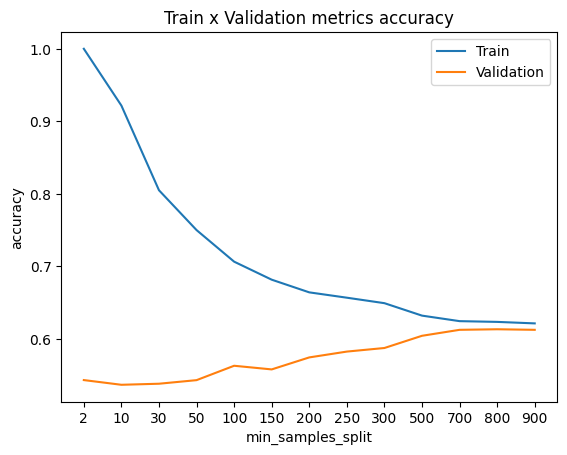

In [122]:
accuracy_list_train = []
accuracy_list_val = []
precision_list_train = []
precision_list_val = []
for min_samples_split in min_samples_s:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    
    precision_train = precision_score(predictions_train,y_train)
    precision_val = precision_score(predictions_val,y_val)
    precision_list_train.append(precision_train)
    precision_list_val.append(precision_val)

plt.title('Train x Validation metrics accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_s )),labels=min_samples_s)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

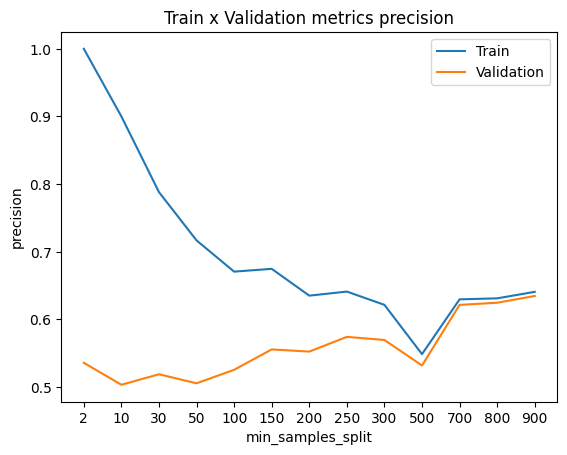

In [123]:
plt.title('Train x Validation metrics precision')
plt.xlabel('min_samples_split')
plt.ylabel('precision')
plt.xticks(ticks = range(len(min_samples_s )),labels=min_samples_s)
plt.plot(precision_list_train)
plt.plot(precision_list_val)
plt.legend(['Train','Validation'])

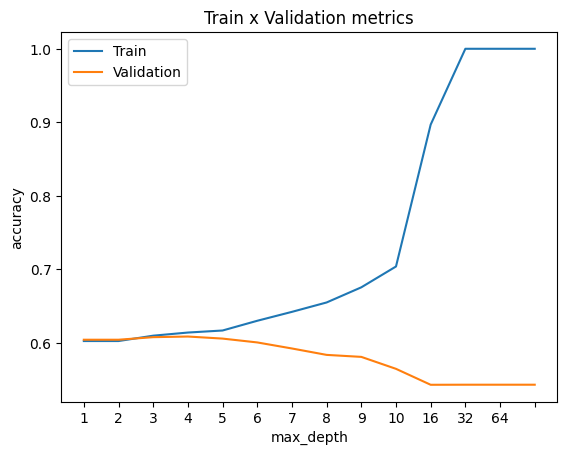

In [124]:
accuracy_list_train = []
accuracy_list_val = []
precision_list_train = []
precision_list_val = []
for max_depth in max_depth_s:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    
    precision_train = precision_score(predictions_train,y_train)
    precision_val = precision_score(predictions_val,y_val)
    precision_list_train.append(precision_train)
    precision_list_val.append(precision_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_s )),labels=max_depth_s)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

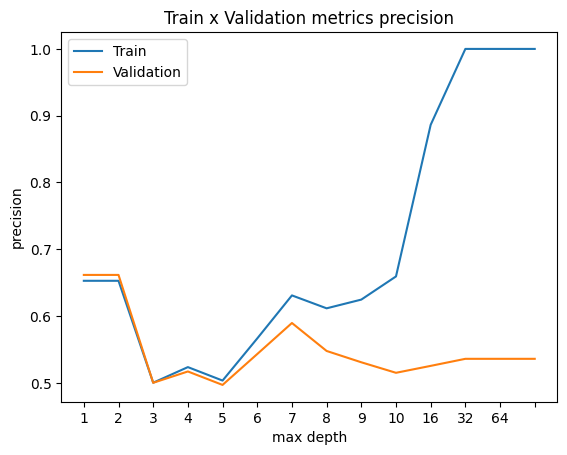

In [125]:
plt.title('Train x Validation metrics precision')
plt.xlabel('max depth')
plt.ylabel('precision')
plt.xticks(ticks = range(len(max_depth_s )),labels=max_depth_s)
plt.plot(precision_list_train)
plt.plot(precision_list_val)
plt.legend(['Train','Validation'])

In [143]:
# demo example max depth 7, split 700/800, all, rf - tryglicerides, bmi, waist, dietary
# another good example with no limits on depth, with split 900, but not checked on validation, overfir risk
decision_tree_model = DecisionTreeClassifier(min_samples_split = 900, 
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [144]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.6215
Metrics validation:
	Accuracy score: 0.6127


In [145]:
print(f"Metrics train:\n\tPrecision score: {precision_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tPrecision score: {precision_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Precision score: 0.6407
Metrics validation:
	Precision score: 0.6346


In [146]:
plt.figure(figsize=(96, 96))
plot_tree(decision_tree_model, filled=True, feature_names=features)
plt.show()

In [147]:
dot_data = export_graphviz(decision_tree_model, out_file=None, 
                           filled=True, feature_names=features,
                           proportion=True)

# Render the DOT file with Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format='png')
graph.view()

'decision_tree.pdf'

Error: no "view" mailcap rules found for type "application/pdf"
Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
Can't call method "get_value" on an undefined value at /usr/bin/mimeopen line 159.


In [131]:
# per case evaluation
df_case_valid = pd.concat([X_val, y_val], axis=1)
## all, basic, rf, bmi-waist, food, 700/7
df_case_valid= df_case_valid[df_case_valid["gender.0"].eq(1) & df_case_valid["age_years.0"].gt(53.5) & 
                             df_case_valid["age_years.0"].le(59.5) & df_case_valid["time_difference.0.2"].gt(4019.5) & df_case_valid["ldl_conv.0"].le(91.313)]
###
print(f"case size (# data points): {len(df_case_valid)}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(df_case_valid[predictors]),df_case_valid[outcome_label]):.4f}")
print(f"Metrics validation:\n\tPrecision score: {precision_score(decision_tree_model.predict(df_case_valid[predictors]),df_case_valid[outcome_label]):.4f}")
# print(df_case)
print(f"zeroes: {len(df_case_valid[df_case_valid[outcome_label].eq(False)])}")
print(f"ones: {len(df_case_valid[df_case_valid[outcome_label].eq(True)])}")


case size (# data points): 10
Metrics validation:
	Accuracy score: 0.9000
Metrics validation:
	Precision score: 1.0000
zeroes: 1
ones: 9


In [132]:
## all, basic, rf, bmi-waist, food, 700/7
df_case = df[df["gender.0"].eq(1) & df["age_years.0"].gt(53.5) & df["age_years.0"].le(59.5) & df["time_difference.0.2"].gt(4019.5) & df["ldl_conv.0"].le(91.313)]
###
# df_case.drop(0, axis=1, inplace=True)
print(f"case size (# data points): {len(df_case)}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(df_case[predictors]),df_case[outcome_label]):.4f}")
print(f"Metrics validation:\n\tPrecision score: {precision_score(decision_tree_model.predict(df_case[predictors]),df_case[outcome_label]):.4f}")
# print(df_case)
print(f"zeroes in case db : {len(df_case[df_case[outcome_label].eq(False)])}")
print(f"ones in case db: {len(df_case[df_case[outcome_label].eq(True)])}")
case_1_file =f"{output_dir}/data_case_1.csv"
df_case.to_csv(case_1_file, sep=',')

case size (# data points): 30
Metrics validation:
	Accuracy score: 0.9333
Metrics validation:
	Precision score: 1.0000
zeroes in case db : 2
ones in case db: 28


In [133]:
# per case evaluation
df_case_2 = pd.concat([X_val, y_val], axis=1)
## all, basic, rf, bmi-waist, food, 700/7
df_case_2 = df_case_2[df_case_2["gender.0"].eq(0) & df_case_2["age_years.0"].gt(53.5) & df_case_2["age_years.0"].le(59.5) & df_case_2["time_difference.0.2"].gt(4019.5) & df_case_2["white_wine_gpd.0"].gt(62.15)]
###
print(f"case size (# data points): {len(df_case_2)}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(df_case_2[predictors]),df_case_2[outcome_label]):.4f}")
print(f"Metrics validation:\n\tPrecision score: {precision_score(decision_tree_model.predict(df_case_2[predictors]),df_case_2[outcome_label]):.4f}")
# print(df_case_2)
print(f"zeroes: {len(df_case_2[df_case_2[outcome_label].eq(False)])}")
print(f"ones: {len(df_case_2[df_case_2[outcome_label].eq(True)])}")

case size (# data points): 162
Metrics validation:
	Accuracy score: 0.5494
Metrics validation:
	Precision score: 1.0000
zeroes: 73
ones: 89


In [134]:
n_estimators_list = [10,50,100,500]

Error: no "view" mailcap rules found for type "application/pdf"
Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
Can't call method "get_value" on an undefined value at /usr/bin/mimeopen line 159.


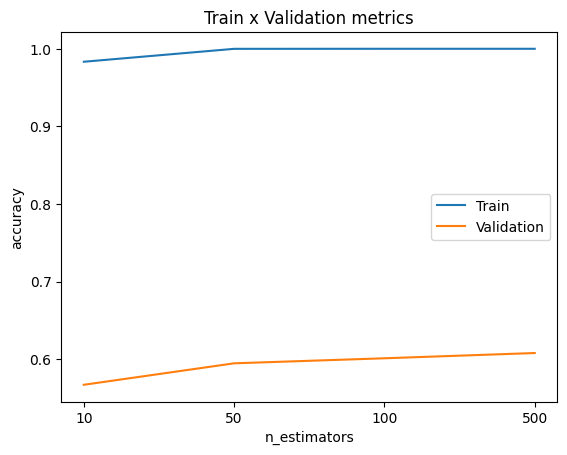

In [135]:
accuracy_list_train = []
accuracy_list_val = []
precision_list_train = []
precision_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    
    precision_train = precision_score(predictions_train,y_train)
    precision_val = precision_score(predictions_val,y_val)
    precision_list_train.append(precision_train)
    precision_list_val.append(precision_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

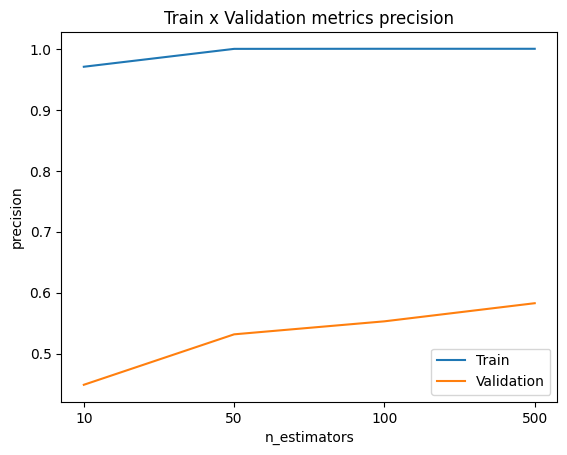

In [136]:
plt.title('Train x Validation metrics precision')
plt.xlabel('n_estimators')
plt.ylabel('precision')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(precision_list_train)
plt.plot(precision_list_val)
plt.legend(['Train','Validation'])

In [137]:
random_forest_model = RandomForestClassifier(n_estimators = 1000).fit(X_train,y_train)

In [142]:
print(f"Metrics train:\n\tAccuracy score tr: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score val: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")
print(f"Metrics train:\n\tPrecision score tr: {precision_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tPrecision score val: {precision_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score tr: 1.0000
Metrics test:
	Accuracy score val: 0.6079
Metrics train:
	Precision score tr: 1.0000
Metrics test:
	Precision score val: 0.5846


In [139]:
xgb_model = XGBClassifier(n_estimators = 900, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train,y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 10)

[0]	validation_0-logloss:0.68603
[1]	validation_0-logloss:0.68084
[2]	validation_0-logloss:0.67642
[3]	validation_0-logloss:0.67297
[4]	validation_0-logloss:0.66992
[5]	validation_0-logloss:0.66760
[6]	validation_0-logloss:0.66564
[7]	validation_0-logloss:0.66412
[8]	validation_0-logloss:0.66281
[9]	validation_0-logloss:0.66171
[10]	validation_0-logloss:0.66084
[11]	validation_0-logloss:0.66002
[12]	validation_0-logloss:0.65965
[13]	validation_0-logloss:0.65911
[14]	validation_0-logloss:0.65882
[15]	validation_0-logloss:0.65841
[16]	validation_0-logloss:0.65828
[17]	validation_0-logloss:0.65802
[18]	validation_0-logloss:0.65779
[19]	validation_0-logloss:0.65788


/home/olha/.pyenv/versions/3.11.1/envs/copula/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.65770
[21]	validation_0-logloss:0.65770
[22]	validation_0-logloss:0.65779
[23]	validation_0-logloss:0.65801
[24]	validation_0-logloss:0.65805
[25]	validation_0-logloss:0.65824
[26]	validation_0-logloss:0.65841
[27]	validation_0-logloss:0.65858
[28]	validation_0-logloss:0.65866
[29]	validation_0-logloss:0.65864
[30]	validation_0-logloss:0.65872
[31]	validation_0-logloss:0.65897


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=900, n_jobs=None,
              num_parallel_tree=None, random_state=20, ...)

In [140]:
print(xgb_model.best_iteration)

21


In [141]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")
print(f"Metrics train:\n\tPrecision score: {precision_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tPrecision score: {precision_score(xgb_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.6689
Metrics test:
	Accuracy score: 0.6095
Metrics train:
	Precision score: 0.6389
Metrics test:
	Precision score: 0.5762
